<a href="https://colab.research.google.com/github/guevelel/COMP4449_Image_Classification/blob/main/Traffic_Signs_COMP4449.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing Traffic Signs
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise. 

In [1]:
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Questions/Notes:
#-


import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout



In [3]:
# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

mkdir: cannot create directory ‘dataroot’: File exists
--2023-04-05 23:46:41--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip.1’

data_1.zip.1        100%[===================>]  30.59M   150MB/s    in 0.2s    

2023-04-05 23:46:43 (150 MB/s) - ‘dataroot/data_1.zip.1’ saved [32074743/32074743]

--2023-04-05 23:46:43--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to r

In [4]:
# Unzip
import zipfile
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

In [5]:
# Load sign names
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
signnames

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

In [6]:
# Load images
signimages = pickle.load(open( dataroot+"train.p", "rb" ) )

The image shows a Turn left ahead sign


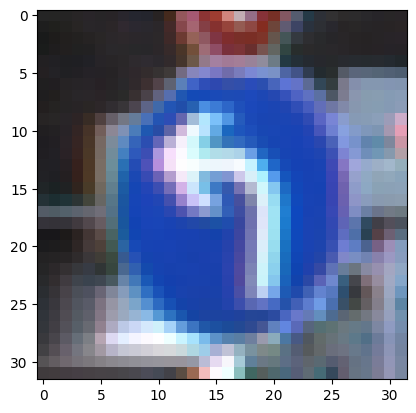

In [7]:
# Preview image
inx = 20123
plt.imshow(signimages['features'][inx])
print("The image shows a {} sign".format(signnames[signimages['labels'][inx]]))

In [8]:
#signimages


In [9]:
len(signimages["features"])

34799

In [10]:
# Load training, validation, and testing images:
train = pickle.load( open( dataroot+"train.p", "rb" ) )
val = pickle.load( open( dataroot+"valid.p", "rb" ) )
test = pickle.load( open( dataroot+"test.p", "rb" ) )

print(train.keys())
type(train)


dict_keys(['coords', 'labels', 'features', 'sizes'])


dict

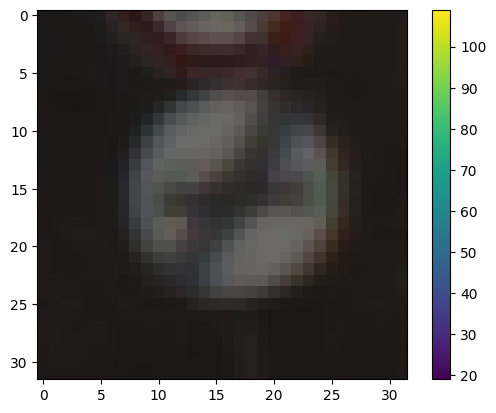

In [11]:

#https://levelup.gitconnected.com/pixels-arrays-and-images-ef3f03638fe7
#A color image is comprised of three channels: red, green, and blue.
#These channels correspond to the those in a single pixel.
#When a computer reads (or writes) an image, it takes the intensity values of each channel in a pixel 
#and stores them in corresponding cells of a 3D-array.

#https://www.tensorflow.org/tutorials/images/classification

plt.figure()
plt.imshow(train['features'][1])
plt.colorbar()
plt.grid(False)
plt.show()


In [12]:
train['labels']
signnames.values()

dict_values(['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric to

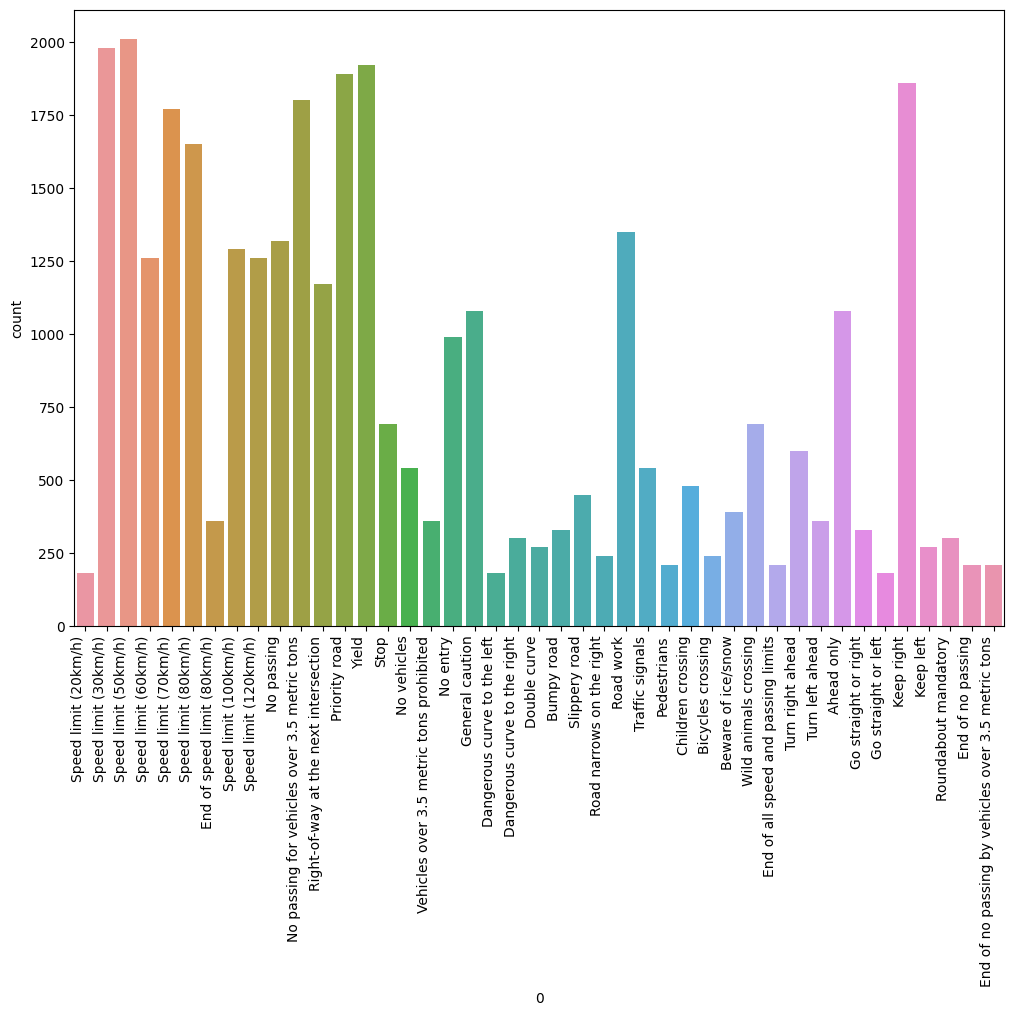

In [13]:
#UPDATE TO INCLUDE ALL 3 TRAIN, TEST, VALID PLOTS?
fig, ax = plt.subplots(figsize=(12, 8))

data = pd.DataFrame(train['labels'])
sns.countplot(data, x=data[0])
ax.set_xticklabels(list(signnames.values()))
plt.xticks(rotation=90, ha='right')
#plt.figure(figsize=(15,10))
plt.show()

In [14]:
#Split out data into training, validation, and test sets:
X_train = train['features']
y_train = train['labels']
X_val = val['features']
y_val = val['labels']
X_test = test['features']
y_test = test['labels']

#need to normalize images to feed into NN:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Reshape and one hot encode:
y_train = tf.one_hot(y_train, 43)
y_val = tf.one_hot(y_val, 43)
y_test = tf.one_hot(y_test, 43)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

#Now, the shape of our data is (34799, 32, 32, 3), where 34799 represents the number of images,
# 32*32 represents the image sizes into pixels, 
#and the last 3 represents the RGB value(availability of coloured data).

number of training examples = 34799
number of test examples = 12630
X_train shape: (34799, 32, 32, 3)
Y_train shape: (34799, 43)
X_val shape: (4410, 32, 32, 3)
Y_val shape: (4410, 43)
X_test shape: (12630, 32, 32, 3)
Y_test shape: (12630, 43)


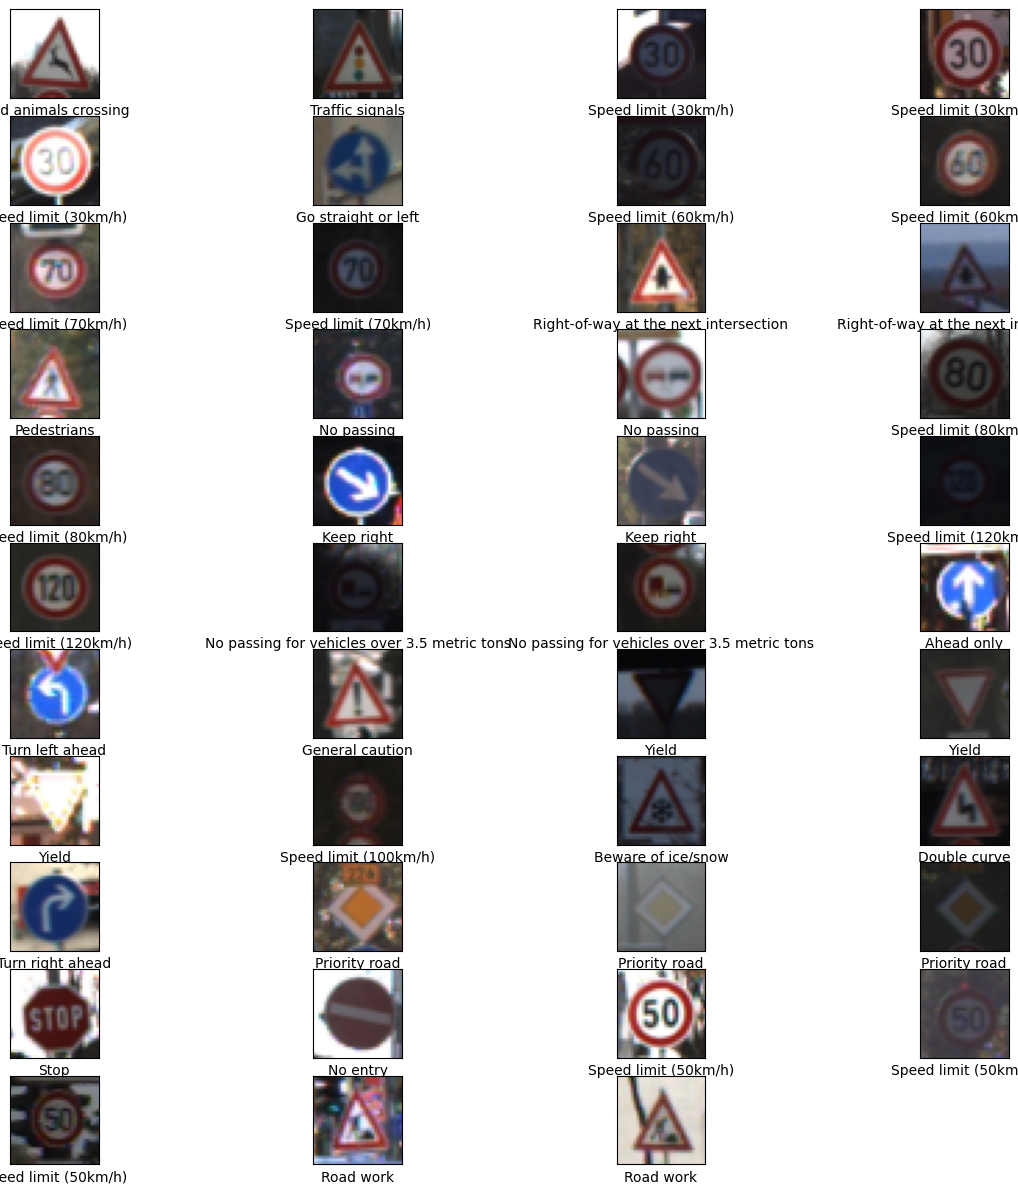

In [15]:
#Visualize all of the different road signs:
plt.figure(figsize=(15,15))
for i in range(808, 34799, 808):
    plt.subplot(11,4,int(i/808))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train['features'][i], cmap=plt.cm.binary)
    plt.xlabel(signnames[signimages['labels'][i]])

#plt.tight_layout#
plt.show()

In [16]:
#What are the coords and sizes columns of the dataset????
print(train.keys())
train['coords']#.shape

dict_keys(['coords', 'labels', 'features', 'sizes'])


array([[  6,   5,  21,  20],
       [  6,   6,  22,  22],
       [  5,   6,  22,  23],
       ...,
       [ 17,  15, 178, 155],
       [ 17,  15, 183, 160],
       [ 20,  18, 211, 184]], dtype=uint8)

In [35]:
#Build Neural Network Model: 

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [36]:
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

eps = 5
history = model.fit(X_train, y_train, batch_size=32, epochs=eps, validation_data=(X_val, y_val))


Epoch 1/5
1088/1088 [==============================] - 152s 139ms/step - loss: 1.1416 - accuracy: 0.6839 - val_loss: 0.4805 - val_accuracy: 0.8757
Epoch 2/5
1088/1088 [==============================] - 153s 140ms/step - loss: 0.3762 - accuracy: 0.8918 - val_loss: 0.4337 - val_accuracy: 0.8844
Epoch 3/5
1088/1088 [==============================] - 155s 143ms/step - loss: 0.2776 - accuracy: 0.9176 - val_loss: 0.3302 - val_accuracy: 0.9100
Epoch 4/5
1088/1088 [==============================] - 151s 139ms/step - loss: 0.2114 - accuracy: 0.9380 - val_loss: 0.3791 - val_accuracy: 0.9197
Epoch 5/5
1088/1088 [==============================] - 164s 150ms/step - loss: 0.1849 - accuracy: 0.9457 - val_loss: 0.3338 - val_accuracy: 0.9213


<ipython-input-37-d78e7cb21221>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-37-d78e7cb21221>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

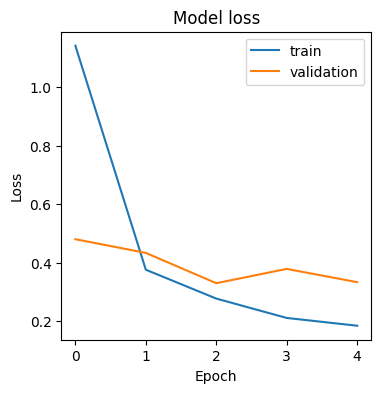

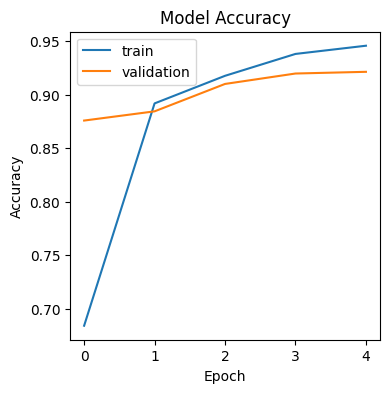

In [37]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(4,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(4,4)).set(xlabel='Epoch',ylabel='Accuracy')


In [38]:
#Assess accuracy on Test set:
model.evaluate(X_test, y_test)

395/395 [==============================] - 11s 27ms/step - loss: 0.4698 - accuracy: 0.9032


[0.469817191362381, 0.9032462239265442]

In [40]:
#history.history
pred = model.predict(X_test)
#pred


395/395 [==============================] - 10s 26ms/step


In [41]:
#Convert label matrices to index values for confustion matrix:
import torch

y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

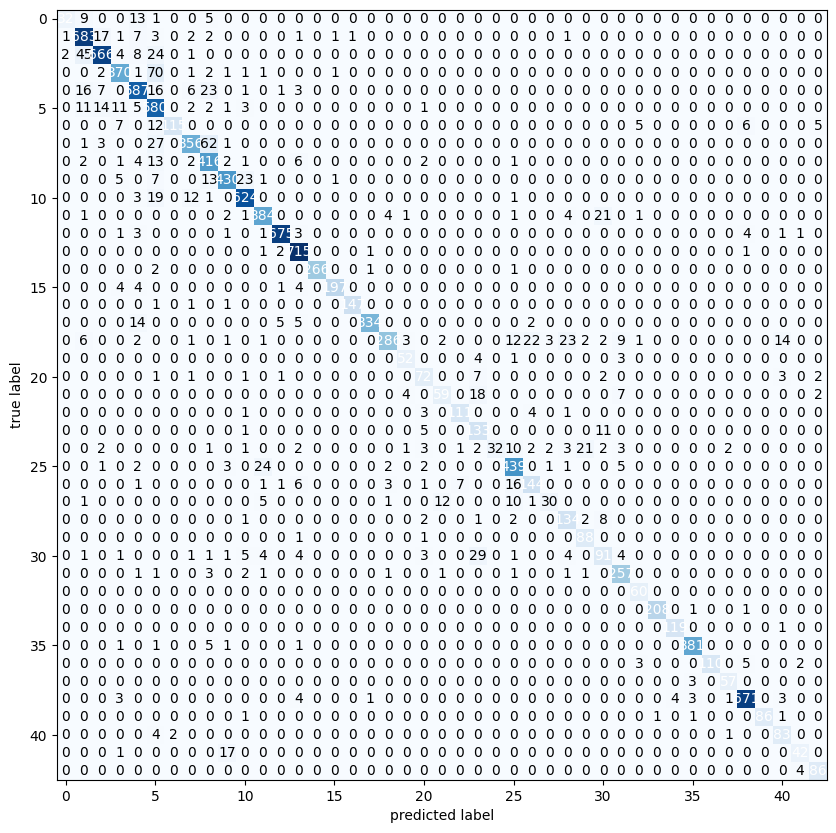

In [42]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

names = list(signnames.values())
names
#class_names = list(signnames.values())
#len(class_names)
#type(class_names)

#Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = 'multiclass', num_classes=43)
confmat_tensor = confmat(preds=y_preds, target=y_act)

#Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    #class_names=names,
    #show_normed=True,
    figsize=(10, 10)
)



In [25]:
#from sklearn import svm

# Support vector classifier
#classifier = svm.SVC(gamma=0.001)

# Learn to classify the training set
#classifier.fit(X_train, y_train)

In [26]:
#Notes:
#use random number generator to mimic incoming image
#
X_train[0].shape
torch.tensor(X_train[0]).shape

torch.Size([32, 32, 3])

In [27]:
# Import PyTorch
import torch
from torch import nn

# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = torch.tensor(X_train[0].T)

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([3, 32, 32]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 1024]) -> [color_channels, height*width]


In [28]:
from torch import nn 
class modelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [29]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = modelV0(
    input_shape=32*32, # this is 28*28
    hidden_units=10, # how mnay units in the hidden layer
    output_shape=43 # one for every class
).to("cpu")

model_0

modelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=43, bias=True)
  )
)

In [30]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [31]:
from sklearn.metrics import accuracy_score

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches

  model_0.train()
  # 1. Forward pass
  y_pred = model_0(X_train)
  
  # 2. Calculate loss (per batch)
  loss = loss_fn(y_pred, y_train)
  train_loss += loss # accumulate train loss
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()
  
  # 4. Loss backward
  loss.backward()
  
  # 5. Optimizer step (update the model's parameters once *per batch*)
  optimizer.step()
    
  
  # Divide total train loss by length of train dataloader
  train_loss /= len(X_train)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode(): 
    for X_test, y_test in X_test, y_test:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += accuracy_score(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(X_test)

    # Calculate the test acc average per batch
    test_acc /= len(X_test)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")



Epoch: 0
------


TypeError: ignored

In [ ]:
#

In [34]:
history.history

{'loss': [0.9994248151779175,
  0.3390883505344391,
  0.23581822216510773,
  0.1838548630475998],
 'accuracy': [0.7187562584877014,
  0.900571882724762,
  0.9303140640258789,
  0.945544421672821],
 'val_loss': [0.4602627456188202,
  0.39705929160118103,
  0.4050183892250061,
  0.4157751202583313],
 'val_accuracy': [0.8678004741668701,
  0.8975056409835815,
  0.8945578336715698,
  0.8925170302391052]}